In [1]:
import random
import os
import pandas as pd

RATIO = 1.0 # percentage of flagged script
DATA_PATH = os.path.expanduser("~/data")

flags = pd.read_json("{}/table_balanced.json".format(DATA_PATH))
flags = flags.drop_duplicates(subset=['sha'])
flags.index = flags.sha

In [40]:
import json
import math
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [47]:
with open("tags.json", 'r') as j:
    tags = json.load(j)

In [48]:
labels = [int(flags.loc[[id]]['flag-any']) for id in tags]

In [49]:
labels = np.array(labels, dtype='int32')

In [50]:
with open('docvecs.npy', 'r') as f:
    features = np.load(f)

In [51]:
print features.shape
print labels.shape
print np.sum(labels) * 1.0 / features.shape[0]

(21443, 128)
(21443,)
0.490090006063


In [52]:
n = features.shape[0]

test_size = int(math.floor(n * 0.15))
indices = np.random.permutation(n)
itrain, idev, itest = indices[test_size*2:], indices[:test_size], indices[test_size:test_size*2]

In [53]:
x_train, x_dev, x_test = features[itrain], features[idev], features[itest]
y_train, y_dev, y_test = labels[itrain], labels[idev], labels[itest]

In [10]:
x_train, y_train

(array([[ 0.05639983, -0.17541032,  0.08903329, ..., -0.01529699,
          0.11383167,  0.09940601],
        [-0.20982258, -0.22833805, -0.03856215, ...,  0.11343701,
          0.19780175,  0.0790746 ],
        [-0.08650759, -0.09515582, -0.0821177 , ..., -0.12093782,
          0.17174672,  0.04418799],
        ..., 
        [ 0.15807985, -0.12120226,  0.32052144, ...,  0.23642761,
          0.42616603,  0.16432247],
        [-0.74940228, -0.0868094 , -0.02433374, ...,  0.30704886,
          0.12681323, -0.47203311],
        [-0.20613727, -0.38821396, -0.0735789 , ...,  0.0499016 ,
          0.33721495,  0.14630041]], dtype=float32),
 array([1, 1, 0, ..., 0, 1, 0], dtype=int32))

In [54]:
best_score = 0.0
best_rf = None

for n_estimators in [50, 60, 70, 80, 90, 100]:
    for mf in ['auto', 'sqrt', 'log2', 0.2]:
        rf = RandomForestClassifier(n_estimators=n_estimators, max_features=mf)
        rf.fit(x_train, y_train)
        score = rf.score(x_dev, y_dev)
        if score > best_score:
            best_rf = rf
            best_score = score

best_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [56]:
best_rf.score(x_train, y_train)

1.0

In [55]:
best_rf.score(x_test, y_test)

0.9008084577114428

In [26]:
X = features[itest]
Y = labels[itest]

In [27]:
norms = np.linalg.norm(X, axis=1)
X = X / norms[:, np.newaxis]

In [34]:
mat = 1.0 - np.dot(X, X.T)
np.fill_diagonal(mat, 0.0)
mat

array([[ 0.        ,  0.80352759,  0.78390634, ...,  0.71599847,
         0.83952737,  0.48722976],
       [ 0.80352759,  0.        ,  0.81609786, ...,  0.75398189,
         0.77912527,  0.83805525],
       [ 0.78390634,  0.81609786,  0.        , ...,  0.81813771,
         0.74823999,  0.76326585],
       ..., 
       [ 0.71599847,  0.75398189,  0.81813771, ...,  0.        ,
         0.91735923,  0.688528  ],
       [ 0.83952737,  0.77912527,  0.74823999, ...,  0.91735923,
         0.        ,  0.90274918],
       [ 0.48722976,  0.83805525,  0.76326585, ...,  0.688528  ,
         0.90274918,  0.        ]], dtype=float32)

In [35]:
tsne = TSNE(perplexity=50, n_components=2, n_iter=5000, metric='precomputed')
X2d = tsne.fit_transform(mat)

In [20]:
flag,  = np.where(Y==1.0)
no_flag, = np.where(Y!=1.0)

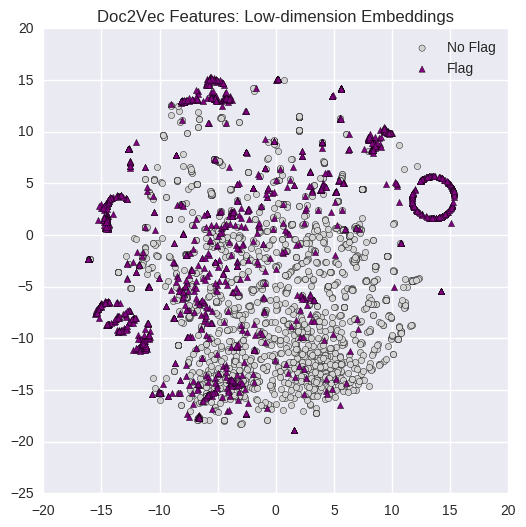

In [37]:
fig, ax1 = plt.subplots(figsize=(6, 6))

ax1.scatter(*X2d[no_flag].T, c='lightgrey', marker='o', label='No Flag', alpha=1.0)
ax1.scatter(*X2d[flag].T, c='purple', marker='^', label='Flag', alpha=1.0)
ax1.legend(loc='upper right')
ax1.set_title("Doc2Vec Features: Low-dimension Embeddings")
plt.show()

In [42]:
y = Y
X = X2d

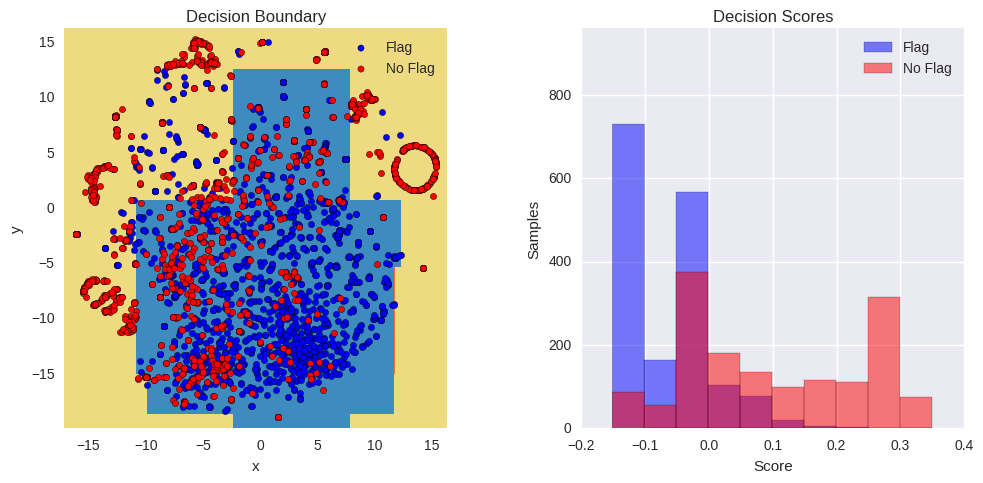

In [45]:
# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)

bdt.fit(X, y)

plot_colors = "br"
plot_step = 0.02
class_names = ["Flag", "No Flag"]

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
plt.subplot(121)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1],
                c=c, cmap=plt.cm.Paired,
                label="%s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary')

# Plot the two-class decision scores
twoclass_output = bdt.decision_function(X)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[y == i],
             bins=10,
             range=plot_range,
             facecolor=c,
             label='%s' % n,
             alpha=.5)
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

In [46]:
bdt.score(X, y)

0.77264267990074442